In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title',
           'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
           'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

train_df = pd.read_csv('/content/train.tsv', sep='\t', names=columns)
test_df = pd.read_csv('/content/test.tsv', sep='\t', names=columns)
val_df = pd.read_csv('/content/valid.tsv', sep='\t', names=columns)

In [9]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nSample:")
print(train_df[['label', 'statement']].head())

print("\nLabel Distribution (Train):")
print(train_df['label'].value_counts())

Train shape: (10240, 14)
Test shape: (1267, 14)

Sample:
         label                                          statement
0        false  Says the Annies List political group supports ...
1    half-true  When did the decline of coal start? It started...
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...
3        false  Health care reform legislation is likely to ma...
4    half-true  The economic turnaround started at the end of ...

Label Distribution (Train):
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


Data Processing

In [10]:
# Binary label mapping
def simplify_label(label):
    if label in ['true', 'mostly-true', 'half-true']:
        return 'real'
    else:
        return 'fake'

train_df['label_binary'] = train_df['label'].apply(simplify_label)
test_df['label_binary'] = test_df['label'].apply(simplify_label)
val_df['label_binary'] = val_df['label'].apply(simplify_label)


In [11]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train_df['clean_statement'] = train_df['statement'].apply(clean_text)
test_df['clean_statement'] = test_df['statement'].apply(clean_text)
val_df['clean_statement'] = val_df['statement'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# TF-IDF Verfication

from sklearn.feature_extraction.text import TfidfVectorizer

# Fit on train and transform all sets
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['clean_statement'])
X_test = vectorizer.transform(test_df['clean_statement'])
X_val = vectorizer.transform(val_df['clean_statement'])

# Labels
y_train = train_df['label_binary']
y_test = test_df['label_binary']
y_val = val_df['label_binary']


Training Models

In [14]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"🔍 {model_name} Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=["real", "fake"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


🔍 Logistic Regression Accuracy: 0.6212

Classification Report:
              precision    recall  f1-score   support

        fake       0.58      0.46      0.51       553
        real       0.64      0.75      0.69       714

    accuracy                           0.62      1267
   macro avg       0.61      0.60      0.60      1267
weighted avg       0.62      0.62      0.61      1267



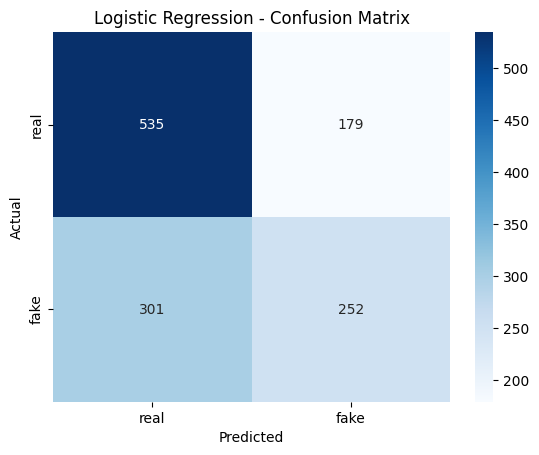

🔍 Multinomial Naive Bayes Accuracy: 0.6038

Classification Report:
              precision    recall  f1-score   support

        fake       0.57      0.36      0.44       553
        real       0.62      0.79      0.69       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.57      1267
weighted avg       0.60      0.60      0.58      1267



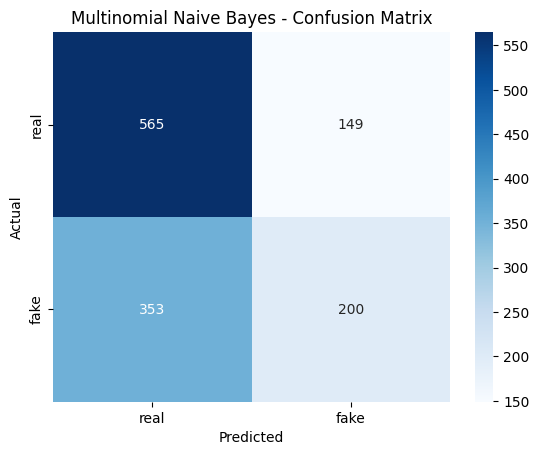

🔍 Random Forest Accuracy: 0.6046

Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.42      0.48       553
        real       0.62      0.75      0.68       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.58      1267
weighted avg       0.60      0.60      0.59      1267



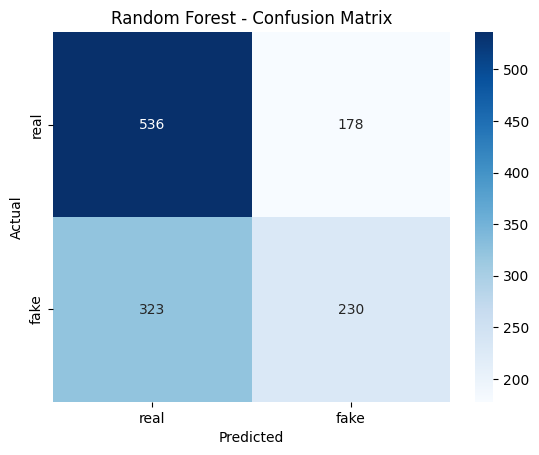

In [15]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, "Logistic Regression")

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
evaluate_model(nb, X_test, y_test, "Multinomial Naive Bayes")

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")


Visualizations

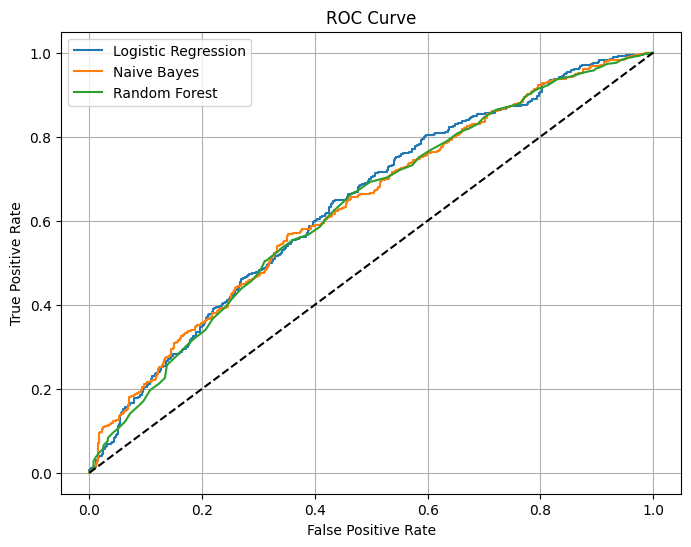

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()

# Get predicted probabilities
lr_probs = lr.predict_proba(X_test)[:, 1]
nb_probs = nb.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]

# Plot ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_bin, lr_probs)
fpr_nb, tpr_nb, _ = roc_curve(y_test_bin, nb_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, rf_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import numpy as np

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = lr.coef_[0]

# Get top positive and negative coefficients
top_positive_idx = np.argsort(coefficients)[-10:]
top_negative_idx = np.argsort(coefficients)[:10]

print("🟢 Top words for 'real' news:")
for idx in reversed(top_positive_idx):
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")

print("\n🔴 Top words for 'fake' news:")
for idx in top_negative_idx:
    print(f"{feature_names[idx]}: {coefficients[idx]:.4f}")


🟢 Top words for 'real' news:
countries: 2.1404
since: 2.0144
percent: 2.0063
day: 2.0060
georgia: 1.8452
average: 1.6633
debt: 1.6529
still: 1.6179
million: 1.6111
months: 1.5449

🔴 Top words for 'fake' news:
wisconsin: -1.6803
illegals: -1.5430
obamacare: -1.5300
deciding: -1.4649
walker: -1.4322
rep: -1.4163
obama: -1.4058
muslim: -1.3678
face: -1.3143
team: -1.2934


In [18]:
# Predict labels
y_pred = lr.predict(X_test)

# Create a dataframe for test results
test_results = test_df.copy()
test_results['predicted'] = y_pred
test_results['true'] = y_test

# Show some misclassified examples
misclassified = test_results[test_results['predicted'] != test_results['true']]
misclassified[['statement', 'true', 'predicted']].sample(5)


,statement,true,predicted
724,"In a lawsuit between private citizens, a Flori...",real,fake
1171,The American Conservative Union gives [Rep. Ti...,fake,real
1092,"McCain ""hasn't held executive responsibility.""",fake,real
338,"Across the country, more than half of the U.S....",fake,real
45,Says as a result of the national health care r...,fake,real


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('statement').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('true').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('predicted').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['true'].value_counts()
    for x_label, grp in _df_5.groupby('statement')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('statement')
_ = plt.ylabel('true')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['predicted'].value_counts()
    for x_label, grp in _df_6.groupby('true')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('true')
_ = plt.ylabel('predicted')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['statement'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='index', y='statement', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['true'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='true', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['predicted'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='index', y='predicted', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Creating App

In [19]:
import joblib

# Save trained model and vectorizer
joblib.dump(lr, 'fake_news_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [23]:
!pip install streamlit

In [24]:
import streamlit as st
import joblib
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load model and vectorizer
model = joblib.load('fake_news_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Streamlit UI
st.title("📰 Fake News Detection App")
st.write("Enter a news statement to check if it's real or fake.")

user_input = st.text_area("News Statement", "")

if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        clean_input = clean_text(user_input)
        vectorized_input = vectorizer.transform([clean_input])
        prediction = model.predict(vectorized_input)[0]
        st.success(f"The statement is predicted to be **{prediction.upper()}**.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-06-11 19:24:44.234 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.245 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.247 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.248 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.248 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 19:24:44.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.